In [51]:
import json
import re
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [52]:
class ABSADataset(Dataset):
    def __init__(self, file_path, saved_file_path = None):
        """
        Initialize the dataset by loading and preprocessing the data.
        """
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        self.model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)
        with open(file_path, 'r') as f:
            raw_data = json.load(f)  # Load raw JSON data
        if saved_file_path is not None and os.path.exists(saved_file_path):
            with open(saved_file_path, 'r') as f:
                self.data = json.load(f)  # Load preprocessed data
            print("Preprocessed data loaded from", saved_file_path)
        else:
            self.data = self.preprocess_data(raw_data)  # Preprocess and store in self.data
            if saved_file_path is not None:
                with open(saved_file_path, 'w') as f:
                    json.dump(self.data, f, indent=4)  # Save preprocessed data
                print("Preprocessed data saved to", saved_file_path)    
        
    """
    Preprocessing rule:
    - Extract the index of each token in the original sentence by taking multiple spaces into account
    - Remove leading and trailing punctuation like ,.!()-{}[]"";:
    - Remove single quotes
    - Skip words that become empty (which means they were only punctuation)
    - Allow an error range of +/- 2 tokens when matching the aspect term
    - Check if the token's prefix matches the start of the aspect term
    - Return -1 if no match is found
    """

    def preprocess_data(self, data):
        """
        Tokenizes and processes data into required format.
        """
        preprocessed_data = []
        for d in data:
            tokens = self.tokenize_data(d["sentence"])
            for term in d['aspect_terms']:
                new_data = {
                    "tokens": [t[0] for t in tokens],  # Extract token words
                    "polarity": term["polarity"],
                    "aspect_term": [term["term"]],
                    "index": self.find_aspect_index(tokens, int(term["from"]), term["term"])
                }
                preprocessed_data.append(new_data)
        return preprocessed_data

    def tokenize_data(self, sentence):
        """
        Tokenizes sentence while preserving exact indices.
        """
        tokens_idx = []
        i = 0
        word = ''
        start_idx = -1

        while i < len(sentence):
            while i < len(sentence) and sentence[i] != ' ':
                if not word:
                    start_idx = i
                word += sentence[i]
                i += 1
            if word:
                tokens_idx.append((word, start_idx))
            word = ''
            i += 1

        return self.clean_tokens(tokens_idx)

    def clean_tokens(self, tokens_idx):
        """
        Cleans tokens by removing punctuation and handling contractions.
        """
        cleaned_tokens = []
        for word, idx in tokens_idx:
            stripped_word = re.sub(r'^[.!(),\[\]{}\'":;-]+|[.!(),\[\]{}\'":;-]+$', '', word)
            stripped_word = stripped_word.replace("'", "")

            if stripped_word:  # Skip empty tokens
                cleaned_tokens.append((stripped_word.lower(), idx))
        return cleaned_tokens

    def find_aspect_index(self, tokens, aspect_from, aspect_term):
        """
        Finds the token index corresponding to the aspect term with an error range of ±2.
        """
        aspect_term = self.tokenize_data(aspect_term)
        for i in range(len(tokens)):
            if aspect_from - 2 <= tokens[i][1] <= aspect_from + 2:
                if tokens[i][0].startswith(aspect_term[0][0]):  # Check prefix match
                    return i
        return -1
    
    def get_token_embeddings(self, tokens, layers=[-4, -3, -2, -1]):
        """
        Get BERT embeddings for a list of tokens.
        """
        encoded = self.tokenizer(tokens, return_tensors="pt", is_split_into_words=True, padding=True, truncation=True)
        
        with torch.no_grad():
            output = self.model(**encoded)

        hidden_states = torch.stack([output.hidden_states[i] for i in layers]).sum(0).squeeze()
        return hidden_states

    def __len__(self):
        """
        Returns the total number of data samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single preprocessed data sample, including computed embeddings.
        """
        sample = self.data[idx]
        embeddings = self.get_token_embeddings(sample["tokens"])  # Compute on-the-fly
        polarity_map = {"positive": 0, "neutral": 2, "negative": 1, "conflict": 3}

        return {
            "tokens": sample["tokens"],
            "embeddings": embeddings,  # Now computed dynamically
            "polarity": polarity_map[sample["polarity"]],
            "aspect_term": sample["aspect_term"],
            "index": sample["index"],
            "seq_length": embeddings.shape[0]  # Store sequence length
        }

In [53]:
train_dataset = ABSADataset("train.json", "train_task_2.json")
val_dataset = ABSADataset("val.json", "val_task_2.json")

Preprocessed data loaded from train_task_2.json
Preprocessed data loaded from val_task_2.json


In [54]:
print(len(train_dataset))
print(len(val_dataset)) 
print(train_dataset[0])
print(val_dataset[0])  

2961
371
{'tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us'], 'embeddings': tensor([[ 1.9976,  3.0614, -2.7381,  ..., -1.5977,  1.8881, -0.6945],
        [ 2.2932,  2.6890, -0.3895,  ...,  2.1881, -1.1270, -0.5891],
        [-0.4416, -0.6662, -2.2985,  ...,  1.4890, -1.8471,  3.0896],
        ...,
        [-1.2842,  1.3957,  1.2688,  ...,  0.6546,  0.2717, -0.5866],
        [-2.6654, -3.8004, -3.8122,  ..., -0.1129, -0.2697,  1.6893],
        [ 1.4150,  1.0325, -0.4854,  ..., -0.1448, -0.0426, -1.0591]]), 'polarity': 1, 'aspect_term': ['staff'], 'index': 2, 'seq_length': 10}
{'tokens': ['I', 'was', 'here', 'a', 'few', 'weeks', 'back', 'and', 'we', 'had', 'the', 'worst', 'customer', 'service', 'experience', 'at', 'a', 'restaurant', 'ever'], 'embeddings': tensor([[ 3.5972,  2.6238, -2.5143,  ..., -0.4186,  1.2370, -0.1547],
        [-1.4033, -0.0940,  0.2786,  ...,  2.8207, -1.3669,  4.2318],
        [ 2.1835, -1.3102,  1.4985,  ...,  2.4183, -1.8050,  2.2127],
      

Reference: https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958

In [57]:
import torch.nn.utils.rnn as rnn_utils

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=2, output_dim=4, dropout=0.3):  # Change output_dim to 4
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, _) = self.lstm(packed_x)  
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  
        out = self.fc(self.dropout(hidden))
        return out

In [63]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for embeddings, labels, lengths in tqdm_bar:
            optimizer.zero_grad()
            outputs = model(embeddings, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tqdm_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / total
        train_accuracy.append(train_acc)
        train_loss.append(total_loss / len(train_loader))  # ✅ Correct averaging

        # Validation
        model.eval()
        val_total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for embeddings, labels, lengths in val_loader:
                outputs = model(embeddings, lengths)
                loss = criterion(outputs, labels)  # ✅ Compute validation loss
                val_total_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_accuracy.append(val_acc)
        val_loss.append(val_total_loss / len(val_loader))  # ✅ Use val_total_loss

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss[-1]:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_lstm_model.pth")
            print("🔥 Best model saved!")

    print(f"🎉 Training complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_loss, val_loss, train_accuracy, val_accuracy

In [64]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [60]:
def collate_fn(batch):
    embeddings, labels, lengths = zip(*[(torch.tensor(sample["embeddings"]), sample["polarity"], sample["seq_length"]) for sample in batch])

    # Pad sequences to max length in the batch
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0)

    return padded_embeddings, torch.tensor(labels), torch.tensor(lengths)


In [65]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [66]:
model = LSTMClassifier()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

Epoch 1/10:   0%|          | 0/93 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_17456\1002749318.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels, lengths = zip(*[(torch.tensor(sample["embeddings"]), sample["polarity"], sample["seq_length"]) for sample in batch])


Epoch 1/10 - Train Loss: 0.8407 - Train Acc: 0.6606 - Val Loss: 0.8282 - Val Acc: 0.6496
🔥 Best model saved!


Epoch 2/10 - Train Loss: 0.6564 - Train Acc: 0.7403 - Val Loss: 0.8826 - Val Acc: 0.6523
🔥 Best model saved!


Epoch 3/10 - Train Loss: 0.5493 - Train Acc: 0.7903 - Val Loss: 0.8248 - Val Acc: 0.6604
🔥 Best model saved!


Epoch 4/10 - Train Loss: 0.4747 - Train Acc: 0.8031 - Val Loss: 0.8595 - Val Acc: 0.6361


Epoch 5/10 - Train Loss: 0.4547 - Train Acc: 0.8149 - Val Loss: 0.8758 - Val Acc: 0.6765
🔥 Best model saved!


Epoch 6/10 - Train Loss: 0.4028 - Train Acc: 0.8291 - Val Loss: 0.9417 - Val Acc: 0.6280


Epoch 7/10 - Train Loss: 0.3723 - Train Acc: 0.8396 - Val Loss: 0.9851 - Val Acc: 0.6469


Epoch 8/10 - Train Loss: 0.3602 - Train Acc: 0.8372 - Val Loss: 0.9815 - Val Acc: 0.6226


Epoch 9/10 - Train Loss: 0.3499 - Train Acc: 0.8386 - Val Loss: 0.9869 - Val Acc: 0.6712


Epoch 10/10 - Train Loss: 0.3114 - Train Acc: 0.8521 - Val Loss: 1.0774 - Val Acc: 0.6334
🎉 Training complete. Best Validation Accuracy: 0.6765


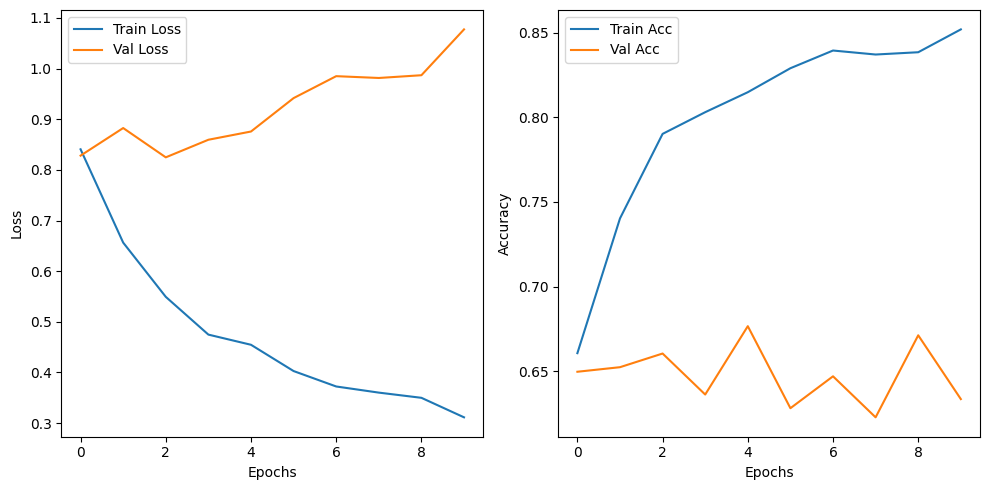

In [67]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [69]:
def load_and_evaluate(model_path = "best_lstm_model.pth", test_file = "val_task_2.json", batch_size=16):
    """
    Load the trained model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = ABSADataset("val.json", test_file)
    
    # Ensure collate_fn is used to handle variable-length sequences
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Define model
    model = LSTMClassifier(output_dim=4)  # Ensure output_dim matches trained model

    # Load saved model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode

    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for embeddings, labels, lengths in tqdm_bar:
            outputs = model(embeddings, lengths)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"✅ Test Accuracy: {accuracy:.2f}%")
    return accuracy

load_and_evaluate()

Preprocessed data loaded from val_task_2.json


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_17456\1002749318.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels, lengths = zip(*[(torch.tensor(sample["embeddings"]), sample["polarity"], sample["seq_length"]) for sample in batch])
Evaluating: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

✅ Test Accuracy: 67.65%


67.65498652291106